In [1]:
#Libraries
import pandas as pd
import pandas as pd
from surprise import Reader, Dataset, KNNBasic, accuracy, PredictionImpossible
from collections import defaultdict
from surprise.model_selection import KFold
from random import shuffle
import matplotlib.pyplot as plt

#Importing the data
data = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/df_under.csv')
data.head()

,userId,wine,rate
0,91cf68cc-9436-43e1-871d-33beef4d2337,Vistamar Cabernet Sauvignon Reserva,1
1,877019f9-3c77-491d-912e-58b2404aed47,Chianti,1
2,eadb1fb9-7260-4618-aa5a-8f2ebdca2077,Bread & Butter Pinor Noir 2020,1
3,c88644be-2c9b-42f0-9c4b-7f8e81795f43,Terrano,1
4,bc79b0e3-064d-4240-86de-e86499f577e8,2/5 大亂鬥 2,1


In [2]:
#metrics
metrics_df = pd.DataFrame(
    columns=['Index','Model','Metric','Optimizer','User_based',
             'RMSE','MAE','MSE', 'Precision', 'Recall', 'Accuracy'])
print(metrics_df)

Empty DataFrame
Columns: [Index, Model, Metric, Optimizer, User_based, RMSE, MAE, MSE, Precision, Recall, Accuracy]
Index: []


In [3]:
class Knn (KNNBasic):
    def __init__(self, sim_options={}, bsl_options={}):
        KNNBasic.__init__(self, sim_options=sim_options, bsl_options=bsl_options)
    
    def create_reader(self, data):
        reader = Reader(rating_scale=(1, 5))
        self.data = Dataset.load_from_df(data[['userId', 'wine', 'rate']], reader)

    def fit (self):
        '''Divide the data into train and test manually '''
        #Frist shuffle the data
        raw_ratings = self.data.raw_ratings
        shuffle(raw_ratings)
        
        #75% of the data for training and the rest for testing
        threshold = int(.80 * len(raw_ratings))
        train_raw_ratings = raw_ratings[:threshold]
        test_raw_ratings = raw_ratings[threshold:]
        
        #Update the data object with train raw ratings
        self.data.raw_ratings = train_raw_ratings
        
        #Define a cross-validation iterator
        kf = KFold(n_splits=5, shuffle= True, random_state=42)
        
        train_rmse_list = []
        test_rmse_list = []
        
        for trainset_fold, testset_fold in kf.split(self.data):
            #Train and test algorithm.
            KNNBasic.fit(self, trainset_fold)
            train_prediction = KNNBasic.test(self, trainset_fold.build_testset())
            prediction = KNNBasic.test(self, testset_fold)

            #Error on training
            train_rmse = accuracy.rmse(train_prediction)
            train_rmse_list.append(train_rmse)

            #Error on testing
            test_rmse = accuracy.rmse(prediction)
            test_rmse_list.append(test_rmse)

        avg_train_rmse = sum(train_rmse_list) / len(train_rmse_list)
        avg_test_rmse = sum(test_rmse_list) / len(test_rmse_list)
        print("###############################################")
        print("The Results are: \n")
        print(f"Average RMSE on Training Set: {avg_train_rmse}")
        print(f"Average RMSE on Test Set: {avg_test_rmse}")

        #Predict ratings for all pairs (u, i) that are NOT in the training set.
        #Update the data object with test raw ratings
        self.data.raw_ratings = test_raw_ratings
        #adapting the Testset to be compatible with Surprise
        testset = self.data.construct_testset(self.data.raw_ratings)
        #Predicting the ratings for testset
        predictions = KNNBasic.test(self, testset)
        #RMSE
        test_rmse = accuracy.rmse(predictions)
        print(f"RMSE on Test Set on UNSEEN DATA is RMSE, : {test_rmse}")

        self.sim = self.compute_similarities()
        self.bu, self.bi = self.compute_baselines()
        return predictions
    
    def get_user_name(self, uid):
        """Return the name of a user from their id.
        Args:
            uid(int): The raw id of the user.
        Returns:
            The name of the user.
        """
        return self.trainset.to_raw_uid(uid)
    
    def get_item_name(self, iid):
        """Return the name of an item from their id.
        Args:
            iid(int): The raw id of the item.
        Returns:
            The name of the item.
        """
        return self.trainset.to_raw_iid(iid)
    
    def get_neighbors_uid(self, user_id, k=10):
        neighbor_ids = self.get_neighbors(user_id, k=10)
        neighbor_names = [self.get_user_name(uid) for uid in neighbor_ids]
        return neighbor_names
    def get_neighbors_iid(self, item_id, k=10):
        neighbor_ids = self.get_neighbors(item_id, k=10)
        neighbor_names = [self.get_item_name(iid) for iid in neighbor_ids]
        return neighbor_names
        
    def get_top_n_for_user(self, predictions,user_id, n=10):
        """Return the top-N recommendation for a user from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            n(int): The number of recommendation to output for each user. Default
                is 10.

        Returns:
        A dict where keys are user (raw) ids and values are lists of tuples:
            [(raw item id, rating estimation), ...] of size n.
        """

        # First map the predictions to each user.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if uid == user_id:
                top_n[uid].append((iid, est))

        # Then sort the predictions for the user and retrieve the k highest ones.
        user_ratings = top_n[user_id]
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[user_id] = user_ratings[:n]

        return top_n[user_id]
    
    def get_top_n_users_for_item(self, predictions, item_id, n=10):
        """Return the top-N users for a specific item from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            item_id: The id of the item for which to get the top-N users.
            n(int): The number of users to output for the item. Default is 10.

        Returns:
        A list of tuples:
            [(raw user id, rating estimation), ...] of size n.
        """

        # First map the predictions to each item.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if iid == item_id:
                top_n[iid].append((uid, est))

        # Then sort the predictions for the item and retrieve the k highest ones.
        item_ratings = top_n[item_id]
        item_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[item_id] = item_ratings[:n]

        return top_n[item_id]

    def estimated(self, u, i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible("User and/or item is unknown.")
        
        #Compute similarities between u and v, where v describes all other
        #users that have also rated item i.
        neighbors = [(v, self.sim[u, v]) for (v, r) in self.trainset.ir[i]]
        # Sort these neighbors by similarity
        neighbors = sorted(neighbors, key=lambda x: x[1], reverse=True)

        print("The 5 nearest neighbors of user", str(u), "are:")
        for v, sim_uv in neighbors[:5]:
            print(f"user {v} with sim {sim_uv:1.15f}")

        # ... Aaaaand return the baseline estimate anyway ;)
        bsl = self.trainset.global_mean + self.bu[u] + self.bi[i]
        return print(f"And the baseline estimate is: {bsl}")
    
    def get_Iu(self, uid):
        """Return the number of items rated by given user
        args:
          uid: the id of the user
        returns:
          the number of items rated by the user
        """
        try:
            return len(self.trainset.ur[self.trainset.to_inner_uid(uid)])
        except ValueError:  # user was not part of the trainset
            return 0

    def get_Ui(self, iid):
        """Return the number of users that have rated given item
        args:
          iid: the raw id of the item
        returns:
          the number of users that have rated the item.
        """
        try:
            return len(self.trainset.ir[self.trainset.to_inner_iid(iid)])
        except ValueError:
            return 0

    def inspect_predictions(self, predictions):
        print(f"uid means the user id and iid means the wine id\n")
        print(f"rui means the actual rating and est means the estimated rating\n")
        print(f"err means the error between the actual and the estimated rating\n")
        print(f"Iu means the number of items rated by given user\n")
        print(f"Ui means the number of users that have rated given item\n")
        # Create a dataframe with the predictions
        df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
        df_pred['Iu'] = df_pred.uid.apply(self.get_Iu)
        df_pred['Ui'] = df_pred.iid.apply(self.get_Ui)
        df_pred['err'] = abs(df_pred.est - df_pred.rui)
        return df_pred
    
    def get_accuracy(self, predictions, k=10, threshold=3.5):
        #Compute RMSE
        rmse = accuracy.rmse(predictions, verbose=True)
        #Compute MAE
        mae = accuracy.mae(predictions, verbose=True)
        # Compute MSE
        mse = accuracy.mse(predictions, verbose=True)

        #Compute precision and recall
        precisions, recalls = self.precision_recall_at_k(predictions, k=k, threshold=threshold)

        #Precision and recall can then be averaged over all users
        precision = sum(prec for prec in precisions.values()) / len(precisions)
        recall = sum(rec for rec in recalls.values()) / len(recalls)
        print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}')

        #Count correct predictions
        correct = 0
        for uid, iid, true_r, est, _ in predictions:
            if round(est) == round(true_r):
                correct += 1

        #Compute accuracy
        accuracy_percentage = correct / len(predictions)
        accuracy_percentage = accuracy_percentage * 100
        print(f"the acc is {accuracy_percentage:.2f}")

        #Return a dictionary with the metrics
        return {'RMSE': rmse, 'MAE': mae, 'MSE': mse, 'Precision': precision, 'Recall': recall, 'Accuracy': accuracy_percentage}
        
    @staticmethod 
    def precision_recall_at_k(predictions, k=10, threshold=3.5):
        """Return precision and recall at k metrics for each user"""
        # First map the predictions to each user.
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))

        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():
            # Sort user ratings by estimated value
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            # Number of relevant items
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            # Number of recommended items in top k
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

            # Number of relevant and recommended items in top k
            n_rel_and_rec_k = sum(
                ((true_r >= threshold) and (est >= threshold))
                for (est, true_r) in user_ratings[:k]
            )

            # Precision@K: Proportion of recommended items that are relevant
            # When n_rec_k is 0, Precision is undefined. We here set it to 0.
            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

            # Recall@K: Proportion of relevant items that are recommended
            # When n_rel is 0, Recall is undefined. We here set it to 0.
            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        return precisions, recalls

## Knn SGD

* knn cosine, user based

In [4]:
knn = Knn(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn.create_reader(data)
predictions = knn.fit()
#acc
metrics = knn.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 1
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3553
RMSE: 0.9745
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3474
RMSE: 1.0093
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3324
RMSE: 1.0501
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3212
RMSE: 1.1228
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3997
RMSE: 1.1133
###############################################
The Results are: 

Average RMSE on Training Set: 0.35122282278639994
Average RMSE on Test Set: 1.0539982489814488
RMSE: 1.2262
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.226200803857513
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.2262
MAE:  1.0127
MSE: 1.5036
Precision: 0.66
Recall: 0.73
the acc is 29.13


/tmp/ipykernel_17306/161991997.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn cosine, item based

In [5]:
knn2 = Knn(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn2.create_reader(data)
predictions = knn2.fit()
#acc
metrics = knn2.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 2
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7267
RMSE: 1.0559
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7542
RMSE: 0.9659
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7009
RMSE: 1.1654
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7317
RMSE: 1.1125
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7166
RMSE: 1.1364
###############################################
The Results are: 

Average RMSE on Training Set: 0.7260146149288044
Average RMSE on Test Set: 1.0872038664410602
RMSE: 1.1113
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.1112974742822845
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.1113
MAE:  0.9393
MSE: 1.2350
Precision: 0.67
Recall: 0.76
the acc is 30.71


/tmp/ipykernel_17306/3130600781.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17306/3130600781.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn mean squared difference, user based

In [6]:
knn3 = Knn(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn3.create_reader(data)
predictions = knn3.fit()
#acc
metrics = knn3.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 3
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1878
RMSE: 1.1295
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1921
RMSE: 1.0996
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1905
RMSE: 1.0434
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2079
RMSE: 1.0416
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1883
RMSE: 1.0923
###############################################
The Results are: 

Average RMSE on Training Set: 0.19332498923364833
Average RMSE on Test Set: 1.0812913502968513
RMSE: 1.1276
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.1276304294308461
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.1276
MAE:  0.9128
MSE: 1.2716
Precision: 0.57
Recall: 0.64
the acc is 33.86


/tmp/ipykernel_17306/3369594395.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17306/3369594395.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn mean squared diference, item based

In [7]:
knn4 = Knn(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn4.create_reader(data)
predictions = knn4.fit()
#acc
metrics = knn4.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 4
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3976
RMSE: 1.1317
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4265
RMSE: 1.1341
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4163
RMSE: 0.9711
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3848
RMSE: 1.2042
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4296
RMSE: 1.0810
###############################################
The Results are: 

Average RMSE on Training Set: 0.4109665474268799
Average RMSE on Test Set: 1.1044188097737067
RMSE: 1.0527
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0526653130682915
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.0527
MAE:  0.8869
MSE: 1.1081
Precision: 0.67
Recall: 0.75
the acc is 34.65


/tmp/ipykernel_17306/1900242280.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17306/1900242280.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn pearson, user based

In [8]:
knn5 = Knn(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn5.create_reader(data)
predictions = knn5.fit()
#acc
metrics = knn5.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 5
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1842
RMSE: 1.1447
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1646
RMSE: 1.1332
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1411
RMSE: 1.1187
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1743
RMSE: 1.1204
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1918
RMSE: 1.0602
###############################################
The Results are: 

Average RMSE on Training Set: 0.17120509688226881
Average RMSE on Test Set: 1.115455107704549
RMSE: 1.0491
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.049085165374445
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.0491
MAE:  0.8804
MSE: 1.1006
Precision: 0.71
Recall: 0.80
the acc is 36.22


/tmp/ipykernel_17306/3339916766.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17306/3339916766.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn pearson, item based

In [9]:
knn6 = Knn(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn6.create_reader(data)
predictions = knn6.fit()
#acc
metrics = knn6.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 6
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1379
RMSE: 1.1243
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2106
RMSE: 1.0847
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2123
RMSE: 1.0795
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1945
RMSE: 1.1420
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1301
RMSE: 1.0689
###############################################
The Results are: 

Average RMSE on Training Set: 0.17709308438067659
Average RMSE on Test Set: 1.099855361890076
RMSE: 1.1226
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.122567175493818
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.1226
MAE:  0.9581
MSE: 1.2602
Precision: 0.62
Recall: 0.67
the acc is 29.13


/tmp/ipykernel_17306/3614094042.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17306/3614094042.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn (shrunk) pearson correlation coefficient, user based

In [10]:
knn7 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn7.create_reader(data)
predictions = knn7.fit()
#acc
metrics = knn7.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 7
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1017
RMSE: 1.1775
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1294
RMSE: 1.0368
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1186
RMSE: 1.2070
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0986
RMSE: 1.0294
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1094
RMSE: 1.0020
###############################################
The Results are: 

Average RMSE on Training Set: 0.11153632179794841
Average RMSE on Test Set: 1.0905459553675363
RMSE: 1.0787
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0787151781791755
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_17306/3960392171.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17306/3960392171.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn (shrunk) pearson correlation coefficient, item based

In [11]:
knn8 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn8.create_reader(data)
predictions = knn8.fit()
#acc
metrics = knn8.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 8
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1188
RMSE: 1.0383
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0853
RMSE: 1.0636
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1262
RMSE: 1.0028
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1156
RMSE: 1.0842
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1222
RMSE: 1.2216
###############################################
The Results are: 

Average RMSE on Training Set: 0.11358579546476925
Average RMSE on Test Set: 1.0820958172073292
RMSE: 1.1191
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.119070198066855
Computing the pearson_baseline similarity matrix.

/tmp/ipykernel_17306/3933834523.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17306/3933834523.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


## Knn Alternating Least Squares (ALS)

* knn cosine, user based

In [12]:
knn9 = Knn(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn9.create_reader(data)
predictions = knn9.fit()
#acc
metrics = knn9.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 9
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3676
RMSE: 1.1464
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3903
RMSE: 1.0586
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3542
RMSE: 1.0427
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3912
RMSE: 1.0403
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3414
RMSE: 1.1456
###############################################
The Results are: 

Average RMSE on Training Set: 0.368931404869523
Average RMSE on Test Set: 1.0867034720678117
RMSE: 1.0904
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0903653104059876
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.0904
MAE:  0.9064
MSE: 1.1889
Precision: 0.62
Recall: 0.72
the acc is 33.86


/tmp/ipykernel_17306/3513140556.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17306/3513140556.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn cosine, item based

In [13]:
knn10 = Knn(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn10.create_reader(data)
predictions = knn10.fit()
#acc
metrics = knn10.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 10
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7726
RMSE: 1.0747
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7549
RMSE: 0.9852
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7542
RMSE: 1.0888
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7307
RMSE: 1.1117
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7397
RMSE: 1.2440
###############################################
The Results are: 

Average RMSE on Training Set: 0.7504327618605477
Average RMSE on Test Set: 1.1008627588380717
RMSE: 1.0657
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.065690565711068
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.0657
MAE:  0.8812
MSE: 1.1357
Precision: 0.56
Recall: 0.63
the acc is 33.86


/tmp/ipykernel_17306/857205367.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17306/857205367.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn mean squared difference, user based

In [14]:
knn11 = Knn(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn11.create_reader(data)
predictions = knn11.fit()
#acc
metrics = knn11.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 11
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1516
RMSE: 1.1951
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1720
RMSE: 1.0281
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1567
RMSE: 1.0287
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1526
RMSE: 1.1200
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1633
RMSE: 0.9840
###############################################
The Results are: 

Average RMSE on Training Set: 0.15923231629412032
Average RMSE on Test Set: 1.0711619909169638
RMSE: 1.1289
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.12893132950397
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.1289
MAE:  0.9243
MSE: 1.2745
Precision: 0.64
Recall: 0.70
the acc is 33.86


/tmp/ipykernel_17306/1804258722.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17306/1804258722.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn mean squared difference, item based

In [15]:
knn12 = Knn(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn12.create_reader(data)
predictions = knn12.fit()
#acc
metrics = knn12.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 12
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4001
RMSE: 1.0841
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4140
RMSE: 1.1457
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3986
RMSE: 0.9994
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.4019
RMSE: 1.0752
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.3998
RMSE: 1.1009
###############################################
The Results are: 

Average RMSE on Training Set: 0.4028764349864189
Average RMSE on Test Set: 1.08109404307265
RMSE: 1.0641
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0640979119368374
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.0641
MAE:  0.8610
MSE: 1.1323
Precision: 0.74
Recall: 0.83
the acc is 41.73


/tmp/ipykernel_17306/262444695.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17306/262444695.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn pearson correlation coefficient, user based

In [16]:
knn13 = Knn(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn13.create_reader(data)
predictions = knn13.fit()
#acc
metrics = knn13.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 13
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1315
RMSE: 1.0028
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1428
RMSE: 1.0913
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1796
RMSE: 1.1195
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1466
RMSE: 1.0663
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1979
RMSE: 1.0492
###############################################
The Results are: 

Average RMSE on Training Set: 0.15970882105589967
Average RMSE on Test Set: 1.0658290809483475
RMSE: 1.2002
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.2001680126856753
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.2002
MAE:  1.0190
MSE: 1.4404
Precision: 0.65
Recall: 0.68
the acc is 25.20


/tmp/ipykernel_17306/1092855449.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17306/1092855449.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn pearson correlation coefficient, item based

In [17]:
knn14 = Knn(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn14.create_reader(data)
predictions = knn14.fit()
#acc
metrics = knn14.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 14
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...


/tmp/ipykernel_17306/3580080987.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17306/3580080987.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


Done computing similarity matrix.
RMSE: 0.1752
RMSE: 1.1280
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1645
RMSE: 1.1179
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2009
RMSE: 1.0591
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1246
RMSE: 1.0903
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1990
RMSE: 1.1281
###############################################
The Results are: 

Average RMSE on Training Set: 0.1728667939038267
Average RMSE on Test Set: 1.1046390955749872
RMSE: 1.1270
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.127031546825981
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.1270
MAE:  0.9463
MSE: 1.2702
Precision: 0.59
Recall: 0.64
the acc is 27.56


* knn (shrunk) pearson correlation coefficient, user based

In [18]:
knn15 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn15.create_reader(data)
predictions = knn15.fit()
#acc
metrics = knn15.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 15
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1150
RMSE: 1.1526
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1151
RMSE: 1.0598
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1203
RMSE: 1.1300
Estimating biases using als...


/tmp/ipykernel_17306/3271800746.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17306/3271800746.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0788
RMSE: 1.0370
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1075
RMSE: 1.0678
###############################################
The Results are: 

Average RMSE on Training Set: 0.1073607521804383
Average RMSE on Test Set: 1.089434888174143
RMSE: 1.0500
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0499791946965822
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0500
MAE:  0.8715
MSE: 1.1025
Precision: 0.65
Recall: 0.70
the acc is 33.86


* knn (shrunk) pearson correlation coefficient, item based

In [19]:
knn16 = Knn(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn16.create_reader(data)
predictions = knn16.fit()
#acc
metrics = knn16.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 16
metrics['Model'] = 'KnnBasic'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1898
RMSE: 1.0743
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1779
RMSE: 1.1029
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1781
RMSE: 1.0825
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1033
RMSE: 1.0217
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1476
RMSE: 1.1108
###############################################
The Results are: 

Average RMSE on Training Set: 0.1593364292151394
Average RMSE on Test Set: 1.0784463989157862
RMSE: 1.0439
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0439418035874826
Computing the pearson_baseline similarity matrix.

/tmp/ipykernel_17306/3154310150.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17306/3154310150.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


In [20]:
metrics_df.sort_values(by='RMSE', ascending=True, inplace=True)
metrics_df

,Index,Model,Metric,Optimizer,User_based,RMSE,MAE,MSE,Precision,Recall,Accuracy
15,16,KnnBasic,(shrunk) pearson corr coeff,ALS,False,1.043942,0.882617,1.089814,0.645000,0.703810,30.708661
4,5,KnnBasic,pearson corr coeff,SGD,True,1.049085,0.880438,1.100580,0.712545,0.801003,36.220472
14,15,KnnBasic,(shrunk) pearson corr coeff,ALS,True,1.049979,0.871522,1.102456,0.651215,0.700231,33.858268
3,4,KnnBasic,MSD,SGD,False,1.052665,0.886950,1.108104,0.669082,0.750000,34.645669
11,12,KnnBasic,MSD,ALS,False,1.064098,0.860984,1.132304,0.739210,0.833172,41.732283
9,10,KnnBasic,Cosine,ALS,False,1.065691,0.881237,1.135696,0.559004,0.627203,33.858268
6,7,KnnBasic,(shrunk) pearson corr coeff,SGD,True,1.078715,0.890355,1.163626,0.570194,0.657077,29.921260
8,9,KnnBasic,Cosine,ALS,True,1.090365,0.906413,1.188897,0.623903,0.716776,33.858268
1,2,KnnBasic,Cosine,SGD,False,1.111297,0.939343,1.234982,0.674228,0.762346,30.708661
7,8,KnnBasic,(shrunk) pearson corr coeff,SGD,False,1.119070,0.918672,1.252318,0.611955,0.690350,31.496063


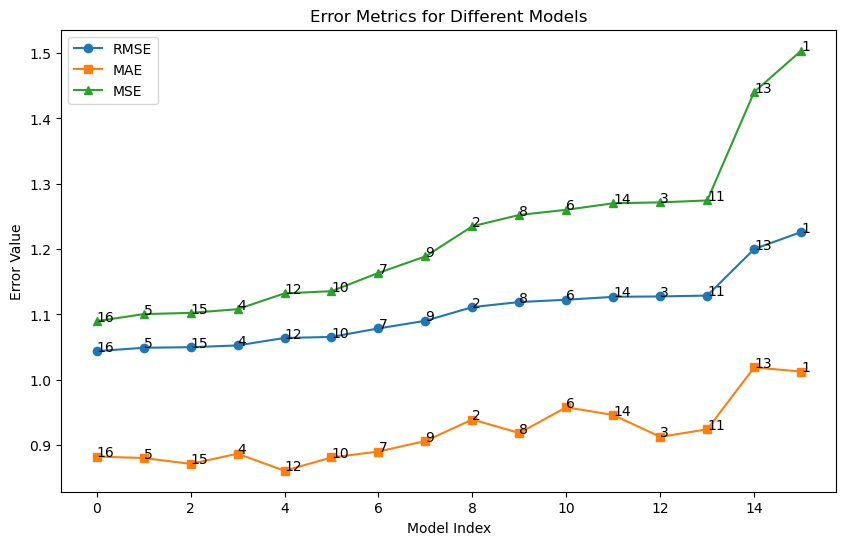

In [21]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MAE'], marker='s', linestyle='-', label='MAE')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MSE'], marker='^', linestyle='-', label='MSE')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MAE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MSE'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

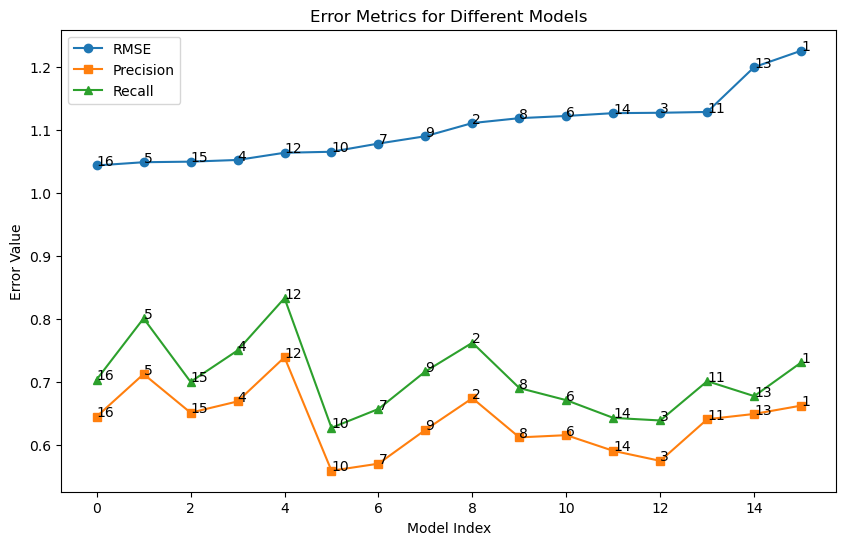

In [22]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Precision'], marker='s', linestyle='-', label='Precision')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Recall'], marker='^', linestyle='-', label='Recall')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Precision'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Recall'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

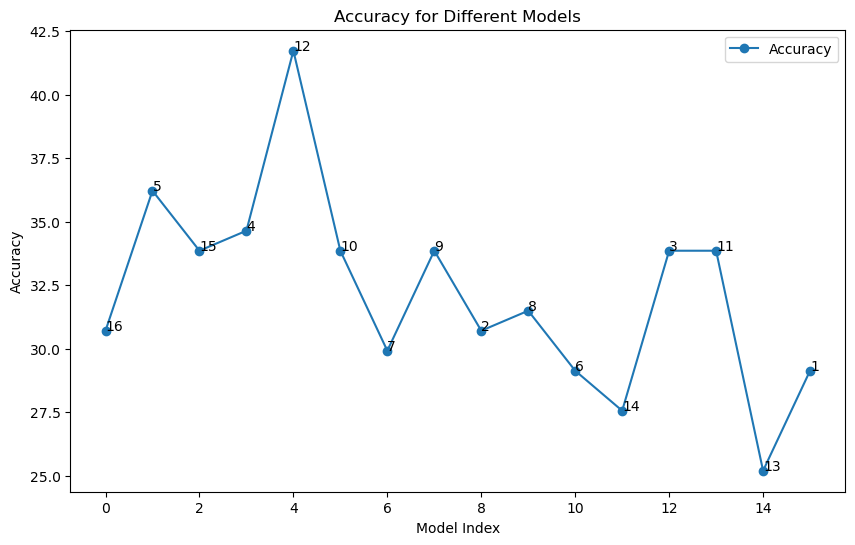

In [23]:
plt.figure(figsize=(10, 6))

#Plot Accuracy with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Accuracy'], marker='o', linestyle='-', label='Accuracy')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Accuracy'].iloc[i]))

#Setting title and labels
plt.title('Accuracy for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Accuracy')

#legend
plt.legend()
plt.show()

## Estimates

In [24]:
knn.estimated(13,20)
print('\n#####\n')
print("Note: If the baseline is {} then the value is a default value, Otherwise not".format(knn.trainset.global_mean))

The 5 nearest neighbors of user 13 are:
user 15 with sim 0.000000000000000
user 55 with sim 0.000000000000000
user 62 with sim 0.000000000000000
And the baseline estimate is: 3.5012783457160963

#####

Note: If the baseline is 3.6856435643564356 then the value is a default value, Otherwise not


In [25]:
df_pred = knn.inspect_predictions(predictions)
best_pred = df_pred.sort_values(by='err')[:10]
worst_pred = df_pred.sort_values(by='err')[-10:]
df_pred.head(10)

uid means the user id and iid means the wine id

rui means the actual rating and est means the estimated rating

err means the error between the actual and the estimated rating

Iu means the number of items rated by given user

Ui means the number of users that have rated given item



,uid,iid,rui,est,details,Iu,Ui,err
0,13016d41-00bd-411c-83f5-2b95691696b7,Vitovska acciaio,4.0,3.643564,"{'was_impossible': True, 'reason': 'Not enough...",10,5,0.356436
1,2a62eecd-b0cd-4395-9f8c-7c912a208be2,Cabernet Sauvignon (Reserva),5.0,3.643564,"{'was_impossible': True, 'reason': 'User and/o...",24,0,1.356436
2,ce7409cd-2e73-490d-adee-95ed9e8d7b75,Aziano Chianti Classico,5.0,3.643564,"{'was_impossible': True, 'reason': 'User and/o...",1,1,1.356436
3,dcd16582-14d2-4e00-a024-9b5886d29b29,Las perdices,5.0,3.643564,"{'was_impossible': True, 'reason': 'User and/o...",6,1,1.356436
4,bc79b0e3-064d-4240-86de-e86499f577e8,2／17 @home #7,4.0,3.643564,"{'was_impossible': True, 'reason': 'User and/o...",27,0,0.356436
5,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Chance,3.0,3.643564,"{'was_impossible': True, 'reason': 'User and/o...",52,0,0.643564
6,5ccd8030-047b-432c-a630-d784ab415756,tschiel brut nature,3.0,3.643564,"{'was_impossible': True, 'reason': 'User and/o...",39,1,0.643564
7,2b88ef27-7d56-4414-9c00-b23851f336d2,refosco Bole,4.0,3.643564,"{'was_impossible': True, 'reason': 'User and/o...",1,1,0.356436
8,bc79b0e3-064d-4240-86de-e86499f577e8,3／17 Temata 2 Cape Crest,5.0,3.643564,"{'was_impossible': True, 'reason': 'User and/o...",27,0,1.356436
9,457b85f5-7b46-4f52-85b9-59acb549b9a2,Limniona Rosé,4.0,3.643564,"{'was_impossible': True, 'reason': 'User and/o...",1,0,0.356436


* best predictions

In [26]:
best_pred

,uid,iid,rui,est,details,Iu,Ui,err
121,2ae69fac-d491-412f-8164-ccaf59a230c2,Ronco del Balbo Merlot,5.0,5.000000,"{'actual_k': 3, 'was_impossible': False}",4,3,0.000000
15,c60f0ff1-ed30-4df6-a612-b9ae7ca0814b,Vitovska,3.0,3.000000,"{'actual_k': 1, 'was_impossible': False}",2,2,0.000000
40,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Bolgheri+,2.0,2.088496,"{'actual_k': 13, 'was_impossible': False}",52,1,0.088496
53,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Corvina,2.0,2.088496,"{'actual_k': 13, 'was_impossible': False}",52,0,0.088496
85,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Pinot grigio,2.0,2.088496,"{'actual_k': 13, 'was_impossible': False}",52,1,0.088496
0,13016d41-00bd-411c-83f5-2b95691696b7,Vitovska acciaio,4.0,3.643564,"{'was_impossible': True, 'reason': 'Not enough...",10,5,0.356436
39,73923070-fce4-46c0-8d85-a99527e73d02,Trebbiano D'Abruzzo,4.0,3.643564,"{'was_impossible': True, 'reason': 'User and/o...",1,1,0.356436
43,5ccd8030-047b-432c-a630-d784ab415756,Rosé vom Löss,4.0,3.643564,"{'was_impossible': True, 'reason': 'User and/o...",39,1,0.356436
44,13016d41-00bd-411c-83f5-2b95691696b7,Vitovska acciaio,4.0,3.643564,"{'was_impossible': True, 'reason': 'Not enough...",10,5,0.356436
46,2a62eecd-b0cd-4395-9f8c-7c912a208be2,Baron amarillo rioja denomacion de origen cali...,4.0,3.643564,"{'was_impossible': True, 'reason': 'User and/o...",24,1,0.356436


* worst predictions

In [27]:
worst_pred

,uid,iid,rui,est,details,Iu,Ui,err
66,91cf68cc-9436-43e1-871d-33beef4d2337,Bella Cabernet Sauvignon,2.0,3.643564,"{'was_impossible': True, 'reason': 'User and/o...",12,1,1.643564
67,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,Petite arvine,2.0,3.643564,"{'was_impossible': True, 'reason': 'User and/o...",18,1,1.643564
69,d838a526-4b0a-4fad-b54f-90b6ca321fca,Shiraz,2.0,3.643564,"{'was_impossible': True, 'reason': 'User and/o...",1,2,1.643564
16,5ccd8030-047b-432c-a630-d784ab415756,Dogliani,2.0,3.643564,"{'was_impossible': True, 'reason': 'User and/o...",39,1,1.643564
82,876b7023-bbf0-4bd8-a341-61ae5bc4b38f,Signoria Prosecco Extra Dry,2.0,3.643564,"{'was_impossible': True, 'reason': 'User and/o...",1,0,1.643564
11,5ccd8030-047b-432c-a630-d784ab415756,Silvaner,2.0,3.643564,"{'was_impossible': True, 'reason': 'User and/o...",39,0,1.643564
21,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,Nus Malvoisie,2.0,3.643564,"{'was_impossible': True, 'reason': 'User and/o...",18,0,1.643564
91,e5b0e77a-ed45-4436-a771-6e01c5782973,Campofiorin Rosso Veronese,1.0,3.643564,"{'was_impossible': True, 'reason': 'User and/o...",0,0,2.643564
59,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,Merlot le vigne di zamo,1.0,3.643564,"{'was_impossible': True, 'reason': 'User and/o...",18,0,2.643564
57,91cf68cc-9436-43e1-871d-33beef4d2337,Vistamar Cabernet Sauvignon Reserva,1.0,3.643564,"{'was_impossible': True, 'reason': 'User and/o...",12,0,2.643564
